## Import Libraries

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm  
import tensorflow as tf
import keras_tuner as kt
import xgboost as xgb
import shap
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from skopt import BayesSearchCV

## Data Preprocessing

In [21]:
# Load Bitcoin historical data
crypto_df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\coin_Bitcoin.csv")

# Load Macroeconomic Indicators data
macro_df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\economic_indicators.csv")

# Convert 'Date' columns to datetime format
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
macro_df['Date'] = pd.to_datetime(macro_df['Date'], format='%Y-%m-%d', errors='coerce')

# Remove time component from crypto_df['Date'] to match macro_df['Date']
crypto_df['Date'] = crypto_df['Date'].dt.date
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'])  # Convert back to datetime

# Filter dataset for dates from 2017 onward
crypto_df = crypto_df[crypto_df['Date'] >= '2017-01-01']
macro_df = macro_df[macro_df['Date'] >= '2017-01-01']

# Merge datasets on 'Date' column
merged_df = pd.merge(crypto_df, macro_df, on='Date', how='left')

# Handle missing values using forward fill
merged_df = merged_df.infer_objects(copy=False)
merged_df.ffill(inplace=True)

# Select key countries for analysis
selected_countries = ['USA', 'China', 'Germany', 'UK', 'India']
merged_df = merged_df[merged_df['Country'].isin(selected_countries)]

# Drop irrelevant column
merged_df.drop(columns=['Unemployment Rate (%)', 'SNo', 'Name', 'Symbol'], inplace=True, errors='ignore')

# Save merged dataset
merged_df.to_csv(r"C:\Users\vaish\OneDrive\UH\Project\new_merged_crypto_macro_data.csv", index=False)
print("Merged dataset saved successfully!")

Merged dataset saved successfully!


## Feature Engineering

Feature engineering completed!


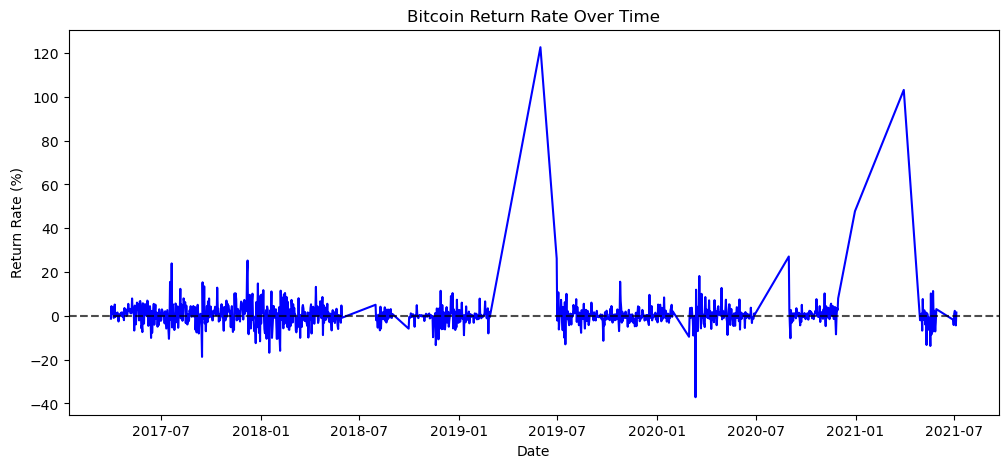

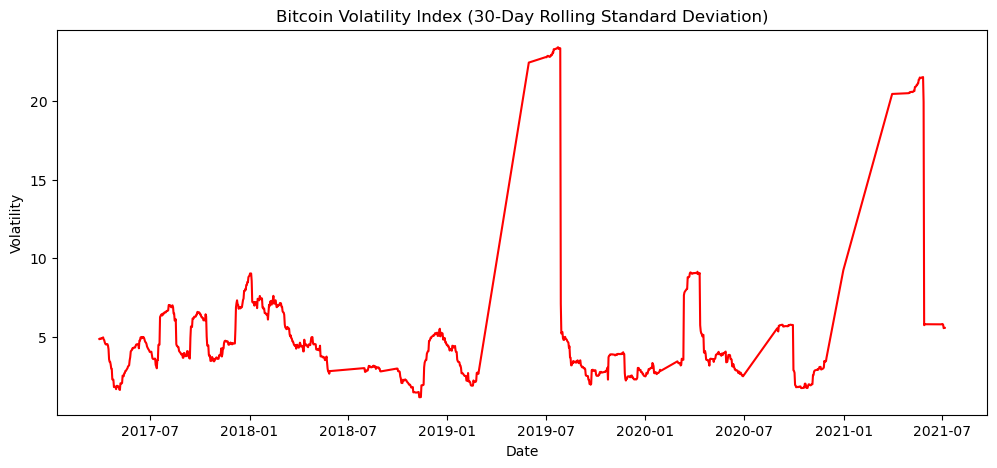

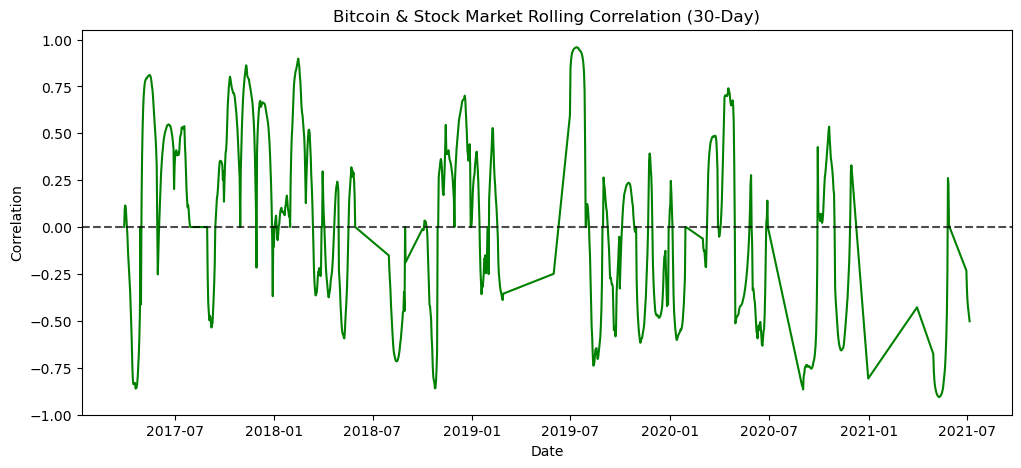

In [23]:
# 1. Load the merged dataset (before feature engineering)
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\new_merged_crypto_macro_data.csv")

# Convert 'Date' column to datetime and set as index for visualization
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove duplicate dates
df = df[~df.index.duplicated(keep='first')]

# 2. Feature Engineering

# Bitcoin Return Rate (Daily Percentage Change)
df['Bitcoin_Return_Rate'] = df['Close'].pct_change() * 100

# Volatility Index (Rolling Standard Deviation of Returns over 30 days)
df['Volatility_Index'] = df['Bitcoin_Return_Rate'].rolling(window=30).std()

# Rolling Correlation (Bitcoin vs Stock Market Index over 30 days)
if 'Stock Index Value' in df.columns:
    # Compute Rolling Correlation only if there's enough variability in both series
    rolling_corr = df['Close'].rolling(window=30).corr(df['Stock Index Value'])
    
    # Handle cases where correlation is undefined or infinite due to constant values
    # Replace 'inf' or 'NaN' values with a specified value 
    rolling_corr.replace([np.inf, -np.inf], np.nan, inplace=True)  
    rolling_corr.fillna(0, inplace=True)  # Fill NaN with 0 
    
    df['Rolling_Correlation'] = rolling_corr
else:
    df['Rolling_Correlation'] = np.nan  # Assign NaN if Stock Index column is missing

# Drop NaN values generated by rolling calculations (first 30 rows)
df.dropna(inplace=True)

# Save the feature-engineered dataset
df.to_csv(r"C:\Users\vaish\OneDrive\UH\Project\new_processed_crypto_macro_data.csv", index=True)

print("Feature engineering completed!")

# 3. Visualization of Engineered Features

# Bitcoin Return Rate Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['Bitcoin_Return_Rate'], color='blue')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title("Bitcoin Return Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Return Rate (%)")
plt.show()

# Bitcoin Volatility Index (30-Day Rolling Standard Deviation)
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['Volatility_Index'], color='red')
plt.title("Bitcoin Volatility Index (30-Day Rolling Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

if 'Stock Index Value' in df.columns:
    df = df.sort_values(by=['Country', 'Date'])

    # Handle duplicates: Aggregate data by taking the mean
    df_unique = df.groupby(['Country', 'Date']).agg({
        'Rolling_Correlation': 'mean'  
    }).reset_index()

    # Plotting the data 
    if 'Rolling_Correlation' in df_unique.columns:
        plt.figure(figsize=(12, 5))
        sns.lineplot(x=df_unique['Date'], y=df_unique['Rolling_Correlation'], color='green')
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        plt.title("Bitcoin & Stock Market Rolling Correlation (30-Day)")
        plt.xlabel("Date")
        plt.ylabel("Correlation")
        plt.show()
    else:
        print("Rolling_Correlation column not found in the data.")

## Support Vector Machine (SVM) Model

Fitting 5 folds for each of 80 candidates, totalling 400 fits

SVM Model Performance:
Root Mean Squared Error (RMSE): 17375.73
Mean Absolute Error (MAE): 10292.28
Mean Absolute Percentage Error (MAPE): 42.09%
SVM Directional Accuracy: 52.56%


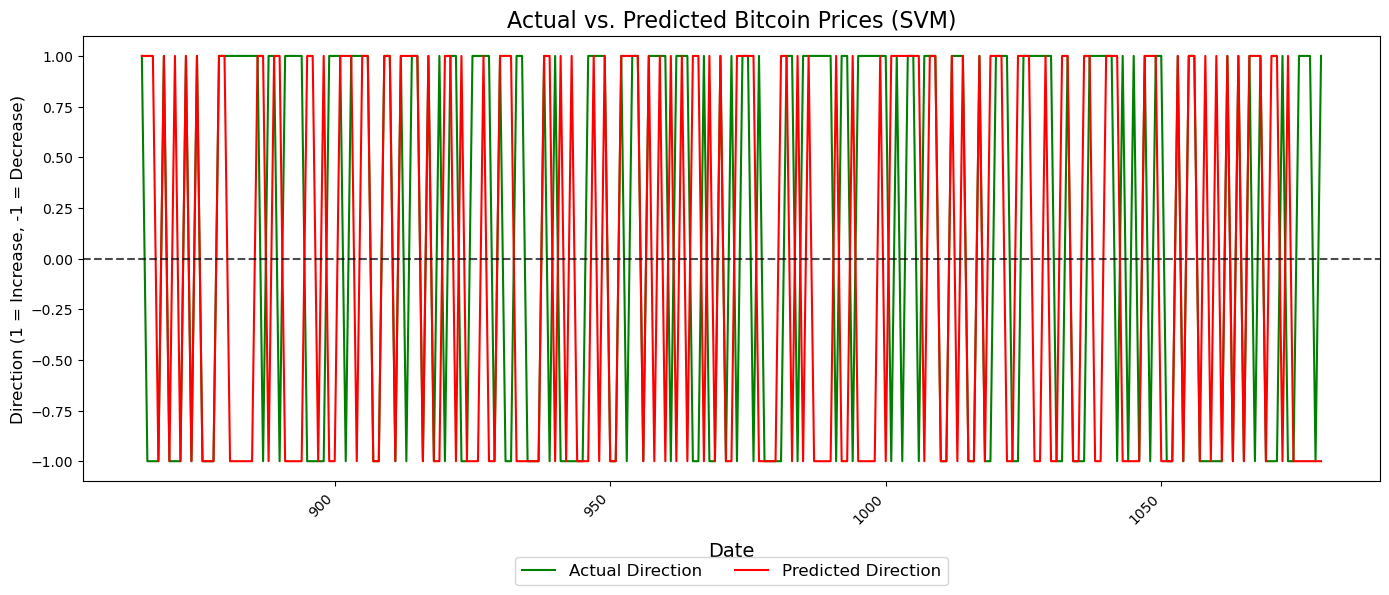

In [25]:
# 1. Load Processed Data & Prepare Features
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\new_processed_crypto_macro_data.csv")

# Define features & target
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation']
target = 'Close'  # Bitcoin closing price

X = df[features]  # Independent variables
y = df[target]  # Target variable

# Split dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 2. Data Scaling

# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Build the model
param_grid = {
    'C': [10, 50, 100, 500, 1000],   # Regularization parameter
    'gamma': ['scale', 0.01, 0.1, 1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.5, 1]  # Margin of tolerance
}

svm_model = SVR(kernel='rbf')

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters found
best_params = grid_search.best_params_

# 4. Train the model with Best Parameters
svm_best = SVR(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])
svm_best.fit(X_train_scaled, y_train)

# Save the trained SVM model
joblib.dump(svm_best, "svm_model.pkl")

# Predict on test data
y_pred_svm = svm_best.predict(X_test_scaled)

# 5. Evaluate Model Performance
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mape_svm = np.mean(np.abs((y_test - y_pred_svm) / y_test)) * 100

# Print evaluation metrics
print("\nSVM Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_svm:.2f}")
print(f"Mean Absolute Error (MAE): {mae_svm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svm:.2f}%")

# Compute Actual & Predicted Price Directions
actual_direction_svm = np.sign(np.diff(y_test))  # 1 if price increased, -1 if decreased
predicted_direction_svm = np.sign(np.diff(y_pred_svm))

# Ensure the index aligns with the diff result
aligned_index = y_test.index[1:]  # Skip the first element

# Compute Directional Accuracy 
directional_accuracy_svm = np.mean(actual_direction_svm == predicted_direction_svm) * 100
print(f"SVM Directional Accuracy: {directional_accuracy_svm:.2f}%")

# 6. Plot Actual vs Predicted Price Directions
plt.figure(figsize=(14, 6))

# Plot actual price directions
sns.lineplot(x=aligned_index, y=actual_direction_svm, label='Actual Direction', color='green')

# Plot predicted price directions
sns.lineplot(x=aligned_index, y=predicted_direction_svm, label='Predicted Direction', color='red')

# Customizing the plot
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)  
plt.title("Actual vs. Predicted Bitcoin Prices (SVM)", fontsize=16)
plt.xlabel("Date", fontsize=14, labelpad=11)  
plt.ylabel("Direction (1 = Increase, -1 = Decrease)", fontsize=12)

# Move legend outside to avoid overlap
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")  

# Add more space at the bottom for x-axis label
plt.subplots_adjust(bottom=0.2)  

# Automatically adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Long Short-Term Memory (LSTM) Model

Reloading Tuner from tuning_results\lstm_tuning\tuner0.json
Best Hyperparameters: {'units': 128, 'dropout': 0.4, 'units_2': 64, 'dropout_2': 0.4, 'learning_rate': 0.01}
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.4118 - val_loss: 0.0995
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0070 - val_loss: 0.0688
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0046 - val_loss: 0.0486
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0037 - val_loss: 0.0406
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027 - val_loss: 0.0266
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - val_loss: 0.0232
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - val_loss: 0.0280
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017 - val_loss: 0.0191
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0015 - val_loss: 0.0179
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012

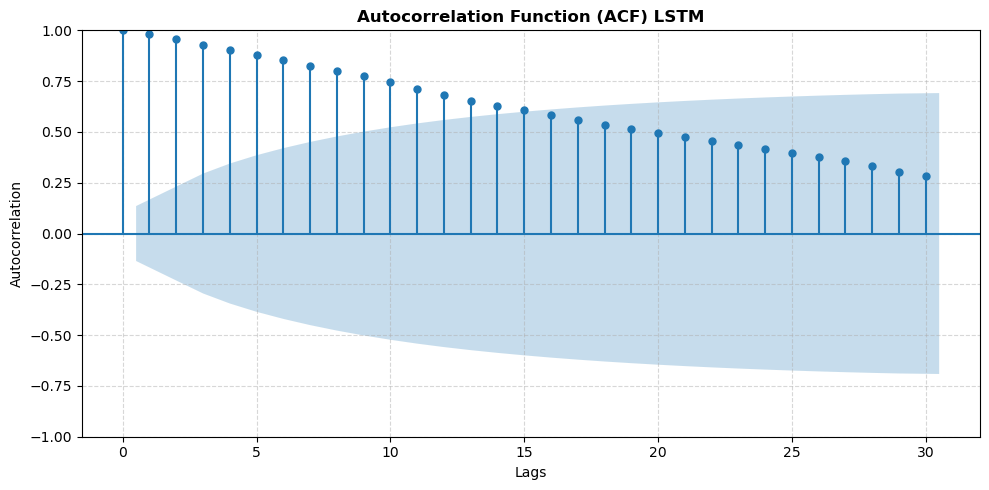

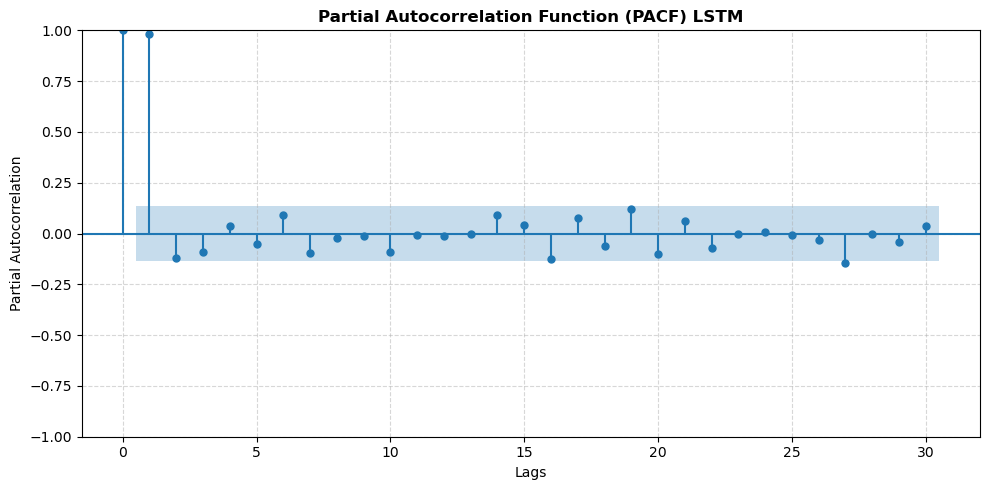

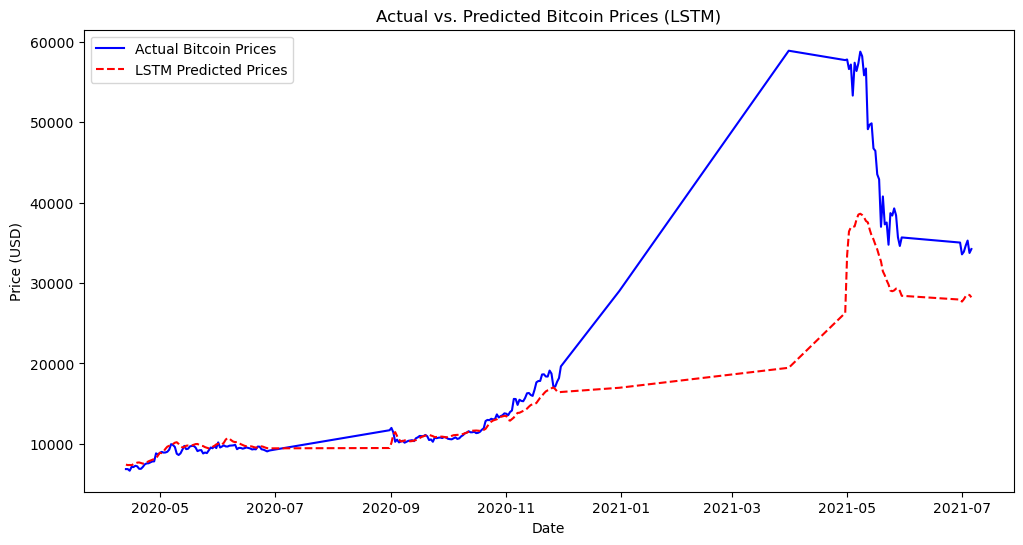

In [27]:
# 1. Load Processed Data & Prepare Features
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\new_processed_crypto_macro_data.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define features & target
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation', 'Close']  
target = 'Close'  # Bitcoin closing price

X = df[features].values  # Independent variables 
y = df[target].values  # Target variable (Bitcoin price)

# 2. Data Scaling

# Normalize features using MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Normalize target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

# Convert Data to Time-Series Format 
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])  # Includes macro indicators + price
        ys.append(y[i+time_steps])  # Future price prediction
    return np.array(Xs), np.array(ys)

# Use past 30 days to predict the next day
time_steps = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split into training (80%) and testing (20%)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 3. Build the model 

# Define the LSTM model for tuning
def build_model(hp):
    model = Sequential([
        Input(shape=(time_steps, X_train.shape[2])),  # Input shape: (time_steps, features)
        LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True),
        Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32), return_sequences=False),
        Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1)
    ])
    
    # Compile with tunable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01])),
                  loss='mse')
    return model

# Define the Keras Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter sets to try
    executions_per_trial=2,  # Train each model twice for stability
    directory='tuning_results',
    project_name='lstm_tuning'
)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=50, batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64]), validation_data=(X_test, y_test))

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# 4. Train the model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save the trained LSTM model
best_model.save("lstm_model.keras")

# Use the trained model for predictions
X_test_fixed = np.array(X_test, dtype=np.float32)
y_pred_scaled = best_model.predict(X_test_fixed)

# Convert predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# 5. Make Predictions & Evaluate Model

# Ensure consistent input shape before prediction
X_test_fixed = np.array(X_test, dtype=np.float32)

# Use tf.function to prevent retracing
@tf.function(reduce_retracing=True)
def make_prediction(model, data):
    return model(data)

# Make predictions
y_pred_scaled = make_prediction(best_model, X_test_fixed)
# Convert predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# Calculate RMSE, MAE, and MAPE
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae_lstm = mean_absolute_error(y_test_actual, y_pred)
mape_lstm = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

# Print results
print("LSTM Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}%")

# Compute Directional Accuracy (%)

# Compute actual & predicted price directions
actual_direction_lstm = np.sign(np.diff(y_test_actual.flatten()))  # 1 if price increased, -1 if decreased
predicted_direction_lstm = np.sign(np.diff(y_pred.flatten()))

# Compute accuracy
directional_accuracy_lstm = np.mean(actual_direction_lstm == predicted_direction_lstm) * 100

# Print Directional Accuracy
print(f"LSTM Directional Accuracy: {directional_accuracy_lstm:.2f}%")

# 6. Compute Autocorrelation Function (ACF) & Partial ACF (PACF)

# Determine safe lags for ACF/PACF (ensures valid range)
max_lags = min(30, len(y_test_actual) - 1, len(y_test_actual) // 2)  # Safe limit for PACF

# Compute & plot ACF only if we have enough data points
if max_lags > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    sm.graphics.tsa.plot_acf(y_test_actual.flatten(), lags=max_lags, ax=ax)  # Pass ax to avoid empty figure
    ax.set_title(f"Autocorrelation Function (ACF) LSTM", fontsize=12, fontweight="bold")
    ax.set_xlabel("Lags", fontsize=10)
    ax.set_ylabel("Autocorrelation", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()  # Adjust layout to prevent cutoff
    plt.show()

    # Compute & plot PACF only if it's within valid range
    if max_lags >= 1:
        fig, ax = plt.subplots(figsize=(10, 5))
        sm.graphics.tsa.plot_pacf(y_test_actual.flatten(), lags=max_lags, ax=ax)  # Pass ax
        ax.set_title(f"Partial Autocorrelation Function (PACF) LSTM", fontsize=12, fontweight="bold")
        ax.set_xlabel("Lags", fontsize=10)
        ax.set_ylabel("Partial Autocorrelation", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for PACF computation. Skipping PACF plot.")
else:
    print("Not enough data for ACF/PACF computation. Skipping both plots.")

# 7. Visualize Predictions vs Actual Prices

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Bitcoin Prices", color='blue')
plt.plot(df.index[-len(y_pred):], y_pred, label="LSTM Predicted Prices", color='red', linestyle='dashed')
plt.title("Actual vs. Predicted Bitcoin Prices (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

## eXtreme Gradient Boosting (XGBoost) Model

Best Parameters: OrderedDict({'learning_rate': 0.13900142856733402, 'max_depth': 9, 'n_estimators': 142, 'subsample': 0.7166664009351126})
RMSE: 2998.5268
MAE: 662.1481
MAPE: 0.82%
XGBoost Directional Accuracy: 93.95%


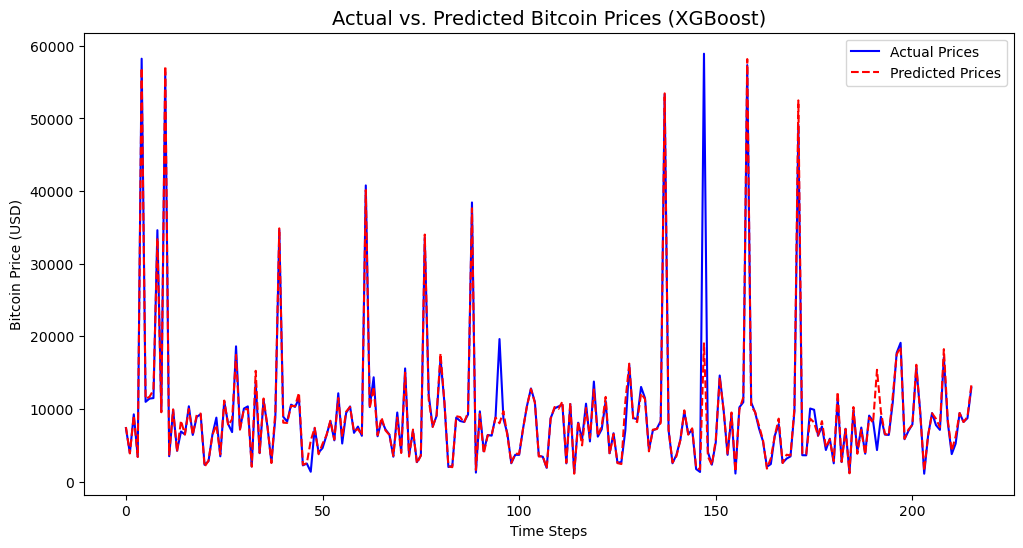

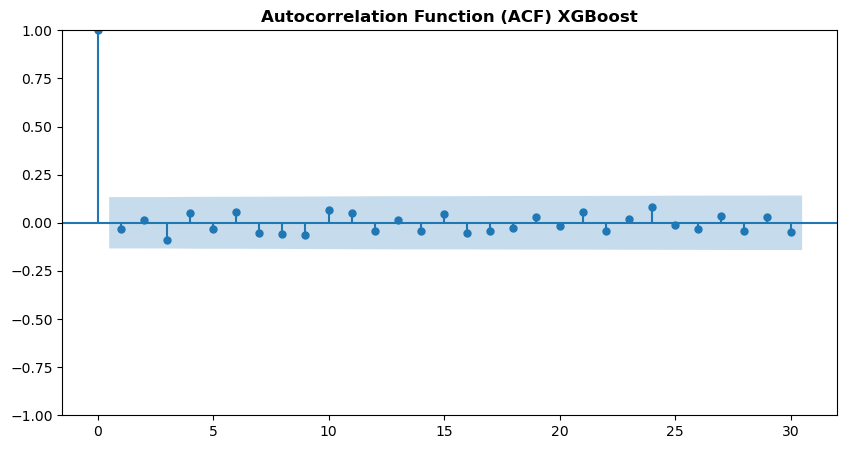

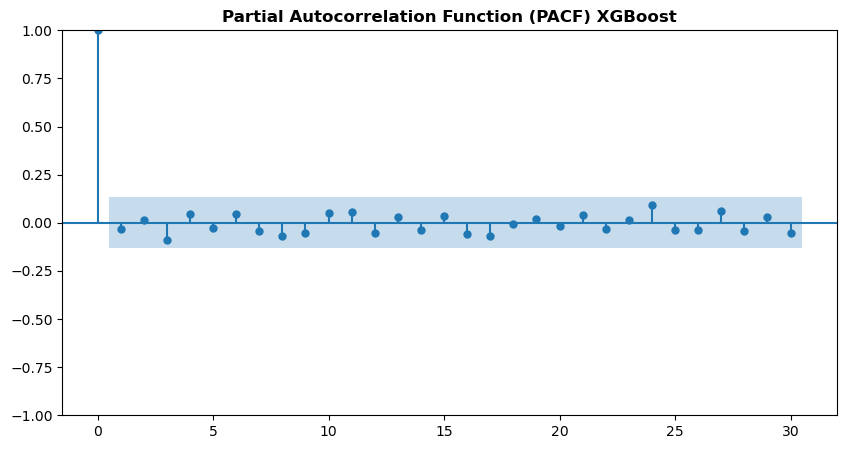

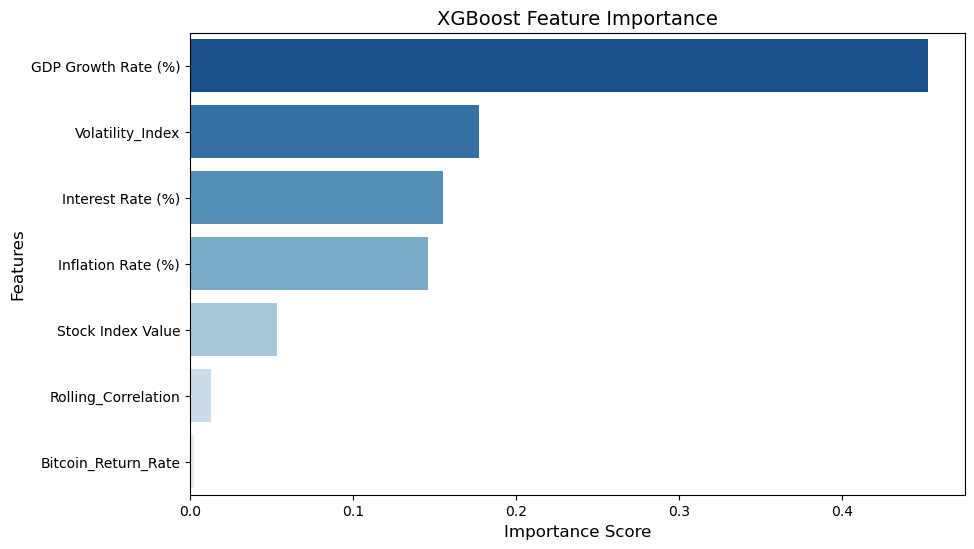

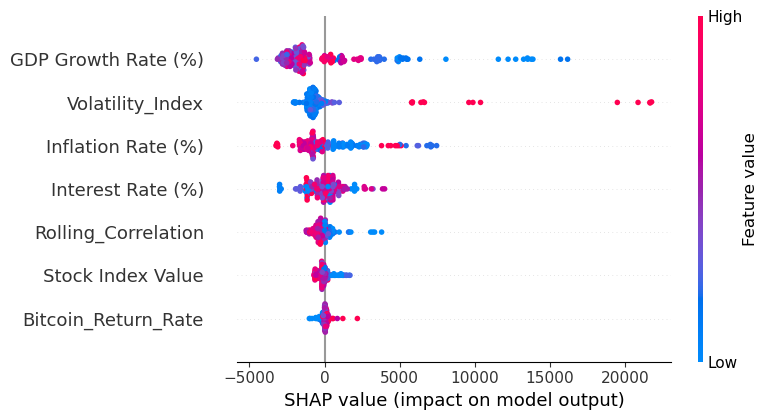

In [29]:
# 1. Load Processed Data & Prepare Features
df = pd.read_csv("new_processed_crypto_macro_data.csv")

# Handling missing values
df.dropna(inplace=True)

# Define features and target 
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation']
target = 'Close'  # Bitcoin closing price

X = df[features]
y = df[target]

# 2. Data Scaling

# Transformation: Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. Build the model

# Define Bayesian optimization search space
param_grid = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (100, 500),
    'subsample': (0.5, 1.0)
}

# Initialize model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Bayesian Optimization
opt = BayesSearchCV(xgb_model, param_grid, n_iter=20, cv=3, random_state=42)
opt.fit(X_train, y_train)

# Best parameters
best_params = opt.best_params_
print("Best Parameters:", best_params)

# 4. Train the model with best parameters
best_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)

#Save the trained xgboost model
best_xgb.save_model("xgboost_model.json")

# 5. Make Predictions & Evaluate Model

# Predictions
y_pred = best_xgb.predict(X_test)

# Evaluation Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)
mape_xgb = np.mean(np.abs((np.log1p(y_test) - np.log1p(y_pred)) / np.log1p(y_test))) * 100

print(f"RMSE: {rmse_xgb:.4f}\nMAE: {mae_xgb:.4f}\nMAPE: {mape_xgb:.2f}%")

# Directional Accuracy
correct_directions = np.sign(y_test.values[1:] - y_test.values[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])
directional_accuracy_xgb = np.mean(correct_directions) * 100
print(f"XGBoost Directional Accuracy: {directional_accuracy_xgb:.2f}%")

# 6. Visualize Predictions vs Actual Prices

# Actual vs. Predicted Price Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Bitcoin Price (USD)")
plt.title("Actual vs. Predicted Bitcoin Prices (XGBoost)", fontsize=14)
plt.legend()
plt.show()

# 7. Compute Autocorrelation Function (ACF) & Partial ACF (PACF)

max_lags = min(30, len(y_test) - 1, len(y_test) // 2)

if max_lags > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    sm.graphics.tsa.plot_acf(y_test, lags=max_lags, ax=ax)
    ax.set_title("Autocorrelation Function (ACF) XGBoost", fontsize=12, fontweight="bold")
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    sm.graphics.tsa.plot_pacf(y_test, lags=max_lags, ax=ax)
    ax.set_title("Partial Autocorrelation Function (PACF) XGBoost", fontsize=12, fontweight="bold")
    plt.show()
    
# 8. Plot Feature Importance & SHAP

# Feature Importance
feature_importance = best_xgb.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Improved Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Blues_r', hue='Feature', legend=False)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# SHAP Analysis
explainer = shap.Explainer(best_xgb)  
shap_values = explainer(X_test)  
shap.summary_plot(shap_values, X_test, feature_names=features)

## Compare Models Performances

Model Performance Comparison:
     Model          RMSE           MAE   MAPE (%)  Directional Accuracy (%)
0      SVM  17375.729033  10292.283190  42.091978                 52.558140
1     LSTM   6549.873325   2912.147017   9.051005                 53.588517
2  XGBoost   2998.526771    662.148099   0.818257                 93.953488


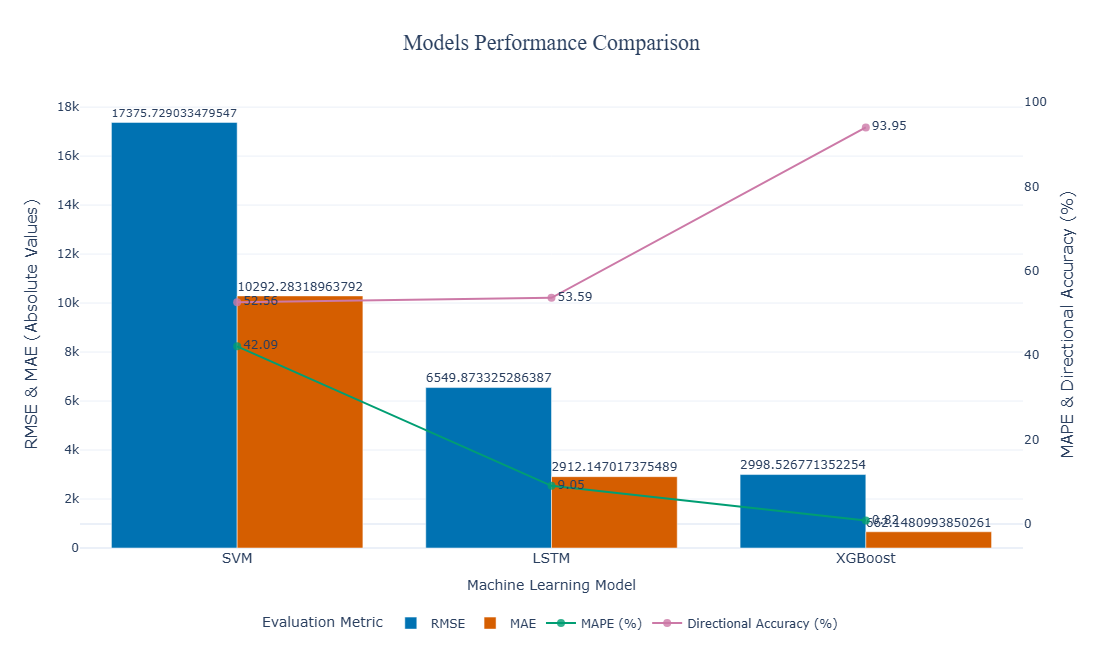

In [31]:
# Create a DataFrame to compare model performance

model_performance = {
    "Model": ["SVM", "LSTM", "XGBoost"],
    "RMSE": [rmse_svm, rmse_lstm, rmse_xgb],
    "MAE": [mae_svm, mae_lstm, mae_xgb],
    "MAPE (%)": [mape_svm, mape_lstm, mape_xgb],
    "Directional Accuracy (%)": [directional_accuracy_svm, directional_accuracy_lstm, directional_accuracy_xgb]
}

# Convert to Pandas DataFrame
performance_df = pd.DataFrame(model_performance)

# Display results
print("Model Performance Comparison:")
print(performance_df)

# Define color-blind-friendly colors
color_palette = {
    "RMSE": "#0072B2",   # Blue
    "MAE": "#D55E00",    # Orange
    "MAPE (%)": "#009E73",  # Green
    "Directional Accuracy (%)": "#CC79A7"  # Pink
}

# Create figure 
fig = go.Figure()

# Add bars for RMSE and MAE (Primary Y-axis)
for metric in ["RMSE", "MAE"]:
    fig.add_trace(go.Bar(
        x=performance_df["Model"],
        y=performance_df[metric],
        name=metric,
        marker_color=color_palette[metric],
        text=performance_df[metric],
        textposition="outside",
        yaxis="y1",
        textfont=dict(size=14)  
    ))

# Add lines for MAPE (%) and Directional Accuracy (%) (Secondary Y-axis)
for metric in ["MAPE (%)", "Directional Accuracy (%)"]:
    fig.add_trace(go.Scatter(
        x=performance_df["Model"],
        y=performance_df[metric],
        name=metric,
        mode="lines+markers+text",
        marker=dict(size=8, color=color_palette[metric], opacity=0.8),
        text=performance_df[metric].round(2),
        textposition="middle right",
        yaxis="y2",
        textfont=dict(size=12)  
    ))

# Layout update for better spacing and clarity
fig.update_layout(
    title=dict(
        text="Models Performance Comparison",
        x=0.5,  # Center title
        font=dict(size=22, family="Arial Bold")  
    ),
    xaxis=dict(title="Machine Learning Model", tickfont=dict(size=14)),
    yaxis=dict(
        title="RMSE & MAE (Absolute Values)",
        titlefont=dict(size=16),  
        showgrid=True,
        zeroline=True
    ),
    yaxis2=dict(
        title="MAPE & Directional Accuracy (%)",
        titlefont=dict(size=16),  
        overlaying="y",
        side="right",
        showgrid=False,
        zeroline=True
    ),
    legend=dict(
        title="Evaluation Metric",
        orientation="h",  
        yanchor="bottom",
        y=-0.2,  
        xanchor="center",
        x=0.5
    ),
    template="plotly_white",
    height=650,  
    width=1000   
)

# Show plot
fig.show()